# Problem Statement 

As a large Single Family Rental (SFR) operator in the US with properties across the country, one of our most important objectives is to determine the "Market Rent" estimate for a given property. An accurate "Market Rent" estimate allows us to rent out properties quickly and fairly and informs the rent at which we send out renewal offers. However, discrepancies between markets, neighborhoods, and properties make this a non-trivial problem.

Your task is to create an algorithm in Python that can calculate a "Market Rent" estimate for a property given its location and some common property attributes. Your model will be trained on the rent level at which nearby properties were rented out over the past two years. A test set is provided, but your model should be able to provide rent estimates for properties outside of the test set as well. Be thoughtful about your approach and be organized in your train of thought. There is no right answer, we just want to see how you think. 

The data that is provided represent dummy, not actual, transactions and properties. However, the distribution of properties should mirror the actual density of our largest SFR markets.

Deliverable:
Create a function that, given a Pandas Dataframe with Latitude, Longitude, Bedrooms, Bathrooms, Square Feet, and 
Year Built, will create a calculated Market Rent column. Please submit in a .ipynb or .py file.

Please include comments as you go and think of ways that you could augment the model. Are there other property
attributes that you think are important? Are there other approaches that you would like to explore given more time?
We want to see everything that you find in the data and support your conclusions with evidence. 



In [3]:
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures

!pip install xgboost
!pip install geopandas pyshp

import xgboost as xgb
print(xgb.__version__)  # This prints the version of XGBoost you have installed

try:
    import sklearn
    print(sklearn.__version__)
    if (sklearn.__version__ < '1.3.0'): #update for latest scikit-learn version
        !pip install -U --user scikit-learn
except Exception as e:
    !pip install scikit-learn
    
sns.set_theme()
print(pd.__version__)

2.0.3
1.3.0
2.1.1


In [4]:
train = pd.read_csv("TrainingSet.csv")
train.head()

,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
0,12/2/2023,4800.0,26.257621,-81.711571,4,3.0,2259,2004
1,12/2/2023,3700.0,34.041742,-84.044686,5,6.0,2951,2002
2,12/2/2023,2400.0,33.205474,-96.664503,4,2.0,1788,2000
3,12/2/2023,1770.0,27.756995,-82.648477,3,1.0,944,1955
4,12/2/2023,1995.0,32.627490,-97.328963,3,2.0,1360,2010


# Multivariate Analysis

Before I started any modeling, I wanted to perform some individual data analysis to see if there were any interesting/significant relationships between any particular independent variables and our predictive value. I also find this useful to see if there are any columns I can combine, or if any data preprocessing is necessary. Ideally, I like to perform this sort of analysis before any EDA to understand what variables to include in my final predictive model but more importantly which variables to omit. 

# Bedrooms Analysis

I decided to group properties with more than 14 bedrooms into a single bucket because I noticed outliers, ranging from 23 to 222 bedrooms, that could affect the accuracy of my model. Interestingly, houses with 14+ bedrooms tend to rent for a similar price as those with 2-5 bedrooms. This is particularly intriguing and warrants further research to understand why a house with 58 bedrooms might rent for significantly less than one with 12 bedrooms.

It was hard to ignore the amount of outliers that existed in lower bedroom houses. For example two and three bedroom houses had a ton of outliers ABOVE box. This could be explained by the variability in quality of homes with less bedrooms. For example, a very nice two bedroom apartment vs a more run down two bedroom apartment will have a huge difference in close price. 

We see less variability as the number of bedrooms increase, possibly because larger houses have smaller differences in quality on average. 

Overall, there is a positive linear correlation between the number of bedrooms and the sale price of a home, which prompted me to include this variable in my model. A boxplot for the number of bedrooms revealed these outliers, leading to the decision to group all properties with more than 14 bedrooms together, as shown in the next cell.


/Users/brianyoung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/brianyoung/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


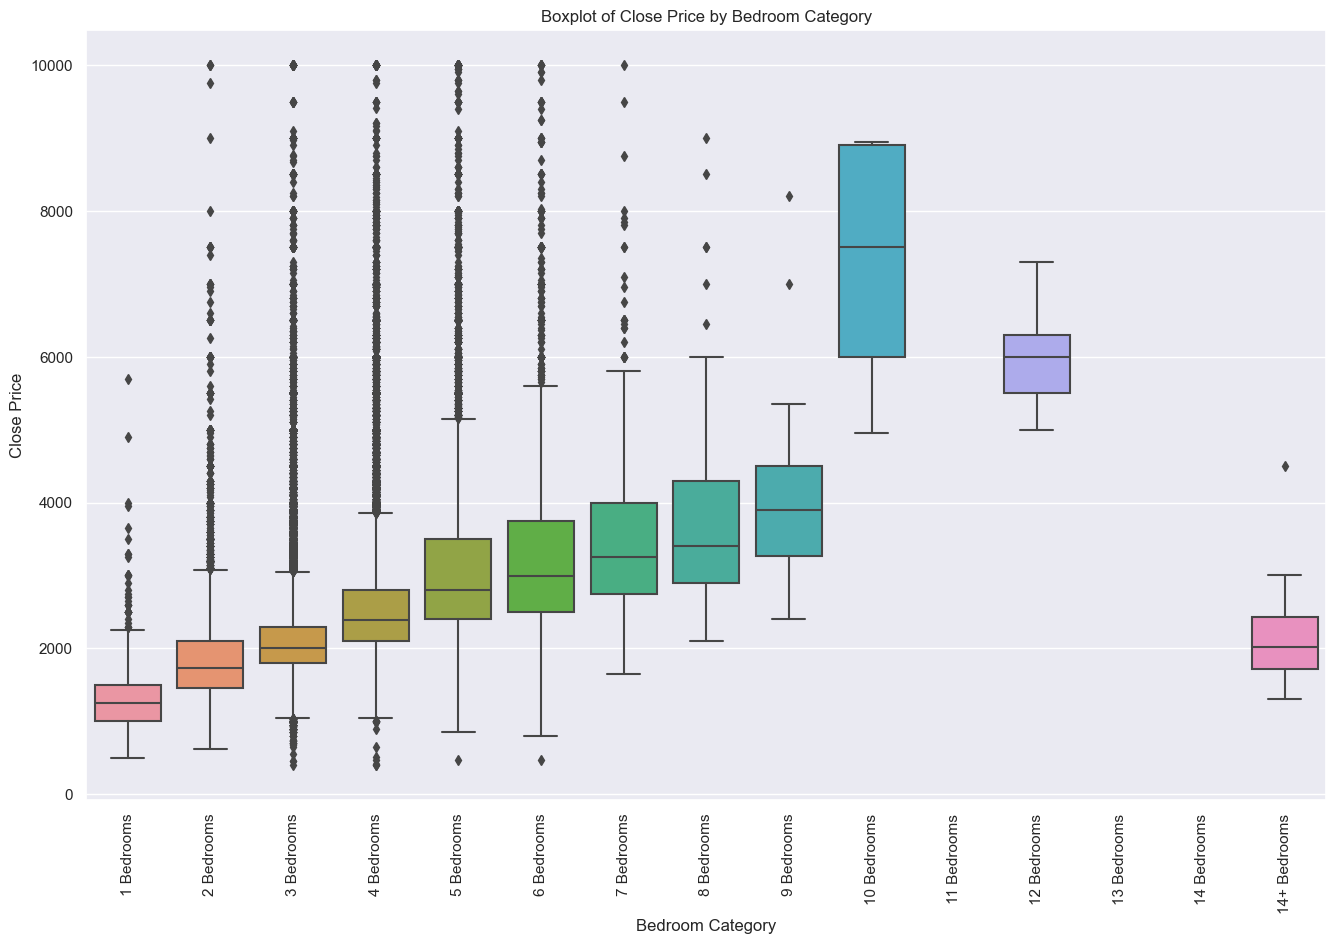

In [5]:
# Define a function to create categories
def categorize_bedrooms(x):
    if x > 14:
        return '14+ Bedrooms'
    else:
        return f'{x} Bedrooms'

# Apply the categorization
train['Bedroom Category'] = train['Bedrooms'].apply(categorize_bedrooms)

# List of categories in order, adjusting to the range you expect in your dataset
categories_ordered = [f'{x} Bedrooms' for x in range(1, 15)] + ['14+ Bedrooms']

# Convert 'Bedroom Category' to a categorical type with a defined order
train['Bedroom Category'] = pd.Categorical(train['Bedroom Category'], categories=categories_ordered, ordered=True)

# Create the boxplot
plt.figure(figsize=(16, 10))
sns.boxplot(x='Bedroom Category', y='Close Price', data=train)

# Set the labels and title
plt.xticks(rotation=90)  # Rotate labels for better readability, adjust as needed
plt.xlabel('Bedroom Category')
plt.ylabel('Close Price')
plt.title('Boxplot of Close Price by Bedroom Category')

# Show the plot
plt.show()


# Bathroom Analysis


The bathroom analysis is similar to the bedroom analysis in that we see a generally positive linear correlation between close price and number of bathrooms. This intuitively makes sense since bedrooms and bathrooms are related physically in the space of a house. 


Again, we see a large number of outlier properties with 15 to 205 bathrooms. I have again decided to group these properties in a bucket as to not detract from my models predictive power.

/Users/brianyoung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/brianyoung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/brianyoung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


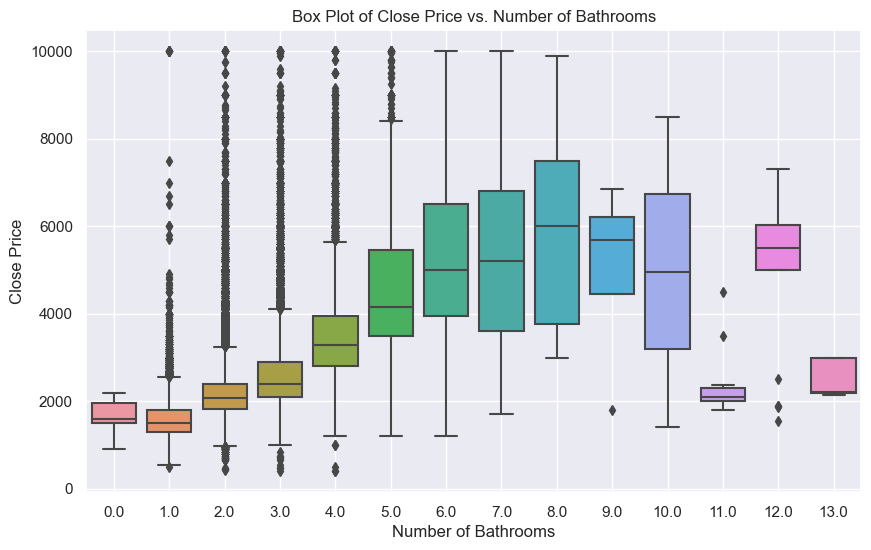

In [6]:
# Round the number of bathrooms to the nearest integer
train['Rounded Bathrooms'] = train['Bathrooms'].round()

# Filter the DataFrame for homes with up to 13 rounded bathrooms
filtered_df = train[train['Rounded Bathrooms'] <= 13]

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rounded Bathrooms', y='Close Price', data=filtered_df)

# Set the labels and title
plt.xlabel('Number of Bathrooms')
plt.ylabel('Close Price')
plt.title('Box Plot of Close Price vs. Number of Bathrooms')

# Add a grid for easier visualization
plt.grid(True)

# Show the plot
plt.show()


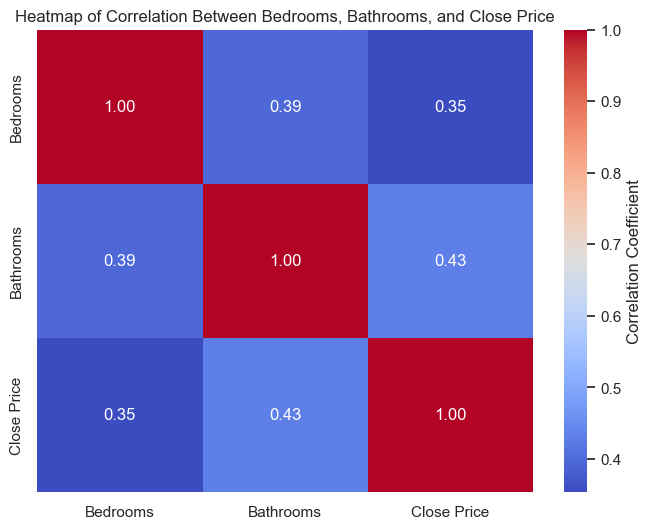

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = train[['Bedrooms', 'Bathrooms', 'Close Price']].corr()

# Generate a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Heatmap of Correlation Between Bedrooms, Bathrooms, and Close Price')
plt.show()

**Short aside, I thought there would be a relatively high co-linearity between bedrooms and bathrooms however this preliminary analysis showed otherwise. Hence, I decided to include both in my predictive model**

# Square Feet Analysis 

Intuitively, square feet should be the biggest indicator of close price. The scatterplot confirms this sentiment as we see a clear positive linear relationship between square feet and close price. 

Again there were outliers larger than 3000 sq ft that made the scatterplot hard to read so I filtered the data to 4000 sq ft to emphasize the relationship betwen close price and square feet.


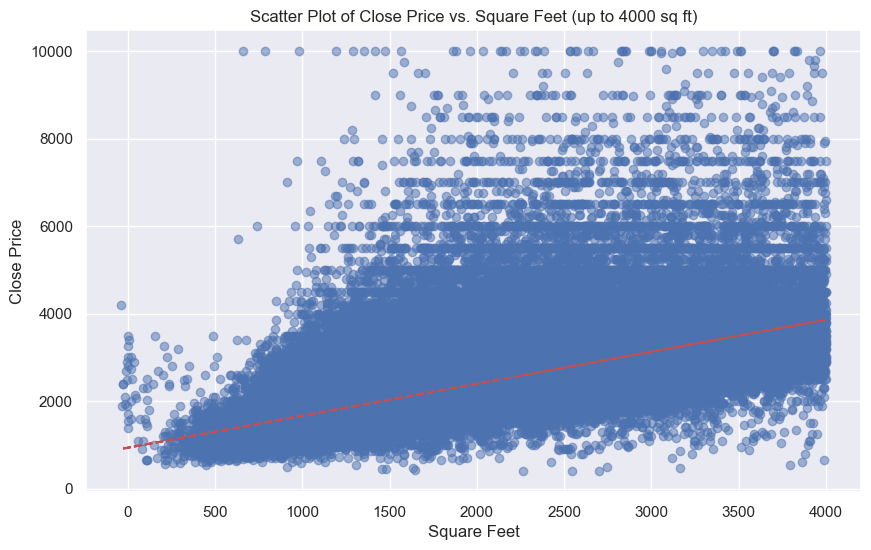

In [8]:
filtered_df = train[train['Square Feet'] <= 4000]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['Square Feet'], filtered_df['Close Price'], alpha=0.5)

# Calculate the trend line
z = np.polyfit(filtered_df['Square Feet'], filtered_df['Close Price'], 1)  # Get the coefficients of the line
p = np.poly1d(z)  # Create a polynomial from the coefficients
plt.plot(filtered_df['Square Feet'], p(filtered_df['Square Feet']), "r--")  # Add the trend line plot

# Set the labels and title
plt.xlabel('Square Feet')
plt.ylabel('Close Price')
plt.title('Scatter Plot of Close Price vs. Square Feet (up to 4000 sq ft)')

# Show the plot with a grid for better visibility
plt.grid(True)
plt.show()


# Year Built Analysis

Year built is interesting as we see an exponential relationship between the year built and the close price. Notice the Y axis as a log of the close price instead of the close price like the rest of the plots. The logarithmic transform makes it a lot easier to see the linear relationship between year built and close price. 




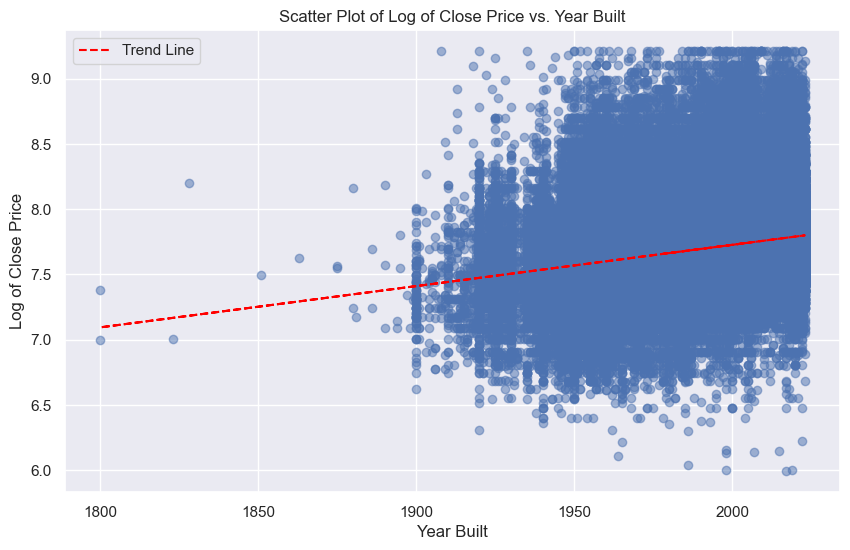

In [9]:
# Calculate the trend line
z = np.polyfit(train['Year Built'], np.log(train['Close Price']), 1)  # Get the coefficients of the line
p = np.poly1d(z)  # Create a polynomial from the coefficients
trend_line_y = p(train['Year Built'])  # Generate y values for the trend line

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(train['Year Built'], np.log(train['Close Price']), alpha=0.5)  # Applying log transformation to Close Price

# Plot the trend line
plt.plot(train['Year Built'], trend_line_y, color='red', linestyle='--', label='Trend Line')

# Set the labels and title
plt.xlabel('Year Built')
plt.ylabel('Log of Close Price')  # Updated label
plt.title('Scatter Plot of Log of Close Price vs. Year Built')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()




# Geographical Analysis

This was actually quite interesting to see as the data made an outline of a map of the united states. Funny that Florida was the most identifiable state in the data. Regardless, intuitively, it didn't seem like longitude or latitude coordinates would be particularly useful in the predictive accuracy of our model. It's evident in the visualization that it's not particularly relevant to close price if a home is father north or farther south. 

While a more intensive analysis of school zone or crime rate would be done if given more time. However, I felt that categorizing coordinates into rural or urban buckets would be sufficient for this exercise.

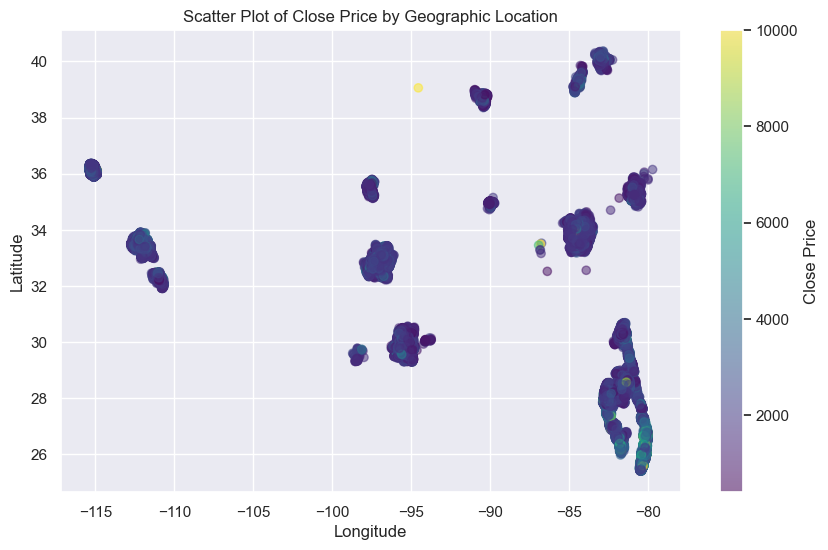

In [10]:
# Create a scatter plot with longitude and latitude as the axes and close price as the color
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train['Longitude'], train['Latitude'], c=train['Close Price'], cmap='viridis', alpha=0.5)

# Add a color bar to the plot to show the close price scale
plt.colorbar(scatter, label='Close Price')

# Set the labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Close Price by Geographic Location')

# Show the plot
plt.show()


**This code is adapted from a stack overflow article [1]. It looks at each point and categorizes it as either urban or rural and adds it as a new column in the dataframe.**

In [11]:
import shapefile
import geopandas as gpd
from shapely.geometry import Point
shp = shapefile.Reader('tl_rd22_us_uac20.shp') #open the shapefile
all_shapes = shp.shapes() # get all the polygons
all_records = shp.records()
polygons_gpd = gpd.GeoDataFrame(geometry=all_shapes) #convert the polygons into a geodataframe


def classify_urban_rural(df, polygons_gpd):
    df['geometry'] = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    points_gpd = gpd.GeoDataFrame(df, geometry='geometry')

    # Perform spatial join between points and polygons
    points_with_polygons = gpd.sjoin(points_gpd, polygons_gpd, how="left", predicate='within')

    # Determine if each point falls within an urban area
    df['Urban'] = points_with_polygons['index_right'].apply(lambda x: True if pd.notna(x) else False)
    return df

train = classify_urban_rural(train, polygons_gpd)


train.head()

,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built,Bedroom Category,Rounded Bathrooms,geometry,Urban
0,12/2/2023,4800.0,26.257621,-81.711571,4,3.0,2259,2004,4 Bedrooms,3.0,POINT (-81.71157055 26.25762099),True
1,12/2/2023,3700.0,34.041742,-84.044686,5,6.0,2951,2002,5 Bedrooms,6.0,POINT (-84.04468638 34.04174233),True
2,12/2/2023,2400.0,33.205474,-96.664503,4,2.0,1788,2000,4 Bedrooms,2.0,POINT (-96.66450257 33.2054737),True
3,12/2/2023,1770.0,27.756995,-82.648477,3,1.0,944,1955,3 Bedrooms,1.0,POINT (-82.64847716 27.75699496),True
4,12/2/2023,1995.0,32.627490,-97.328963,3,2.0,1360,2010,3 Bedrooms,2.0,POINT (-97.32896283 32.62748954),True


**Surprisingly, there doesn't seem to be a huge difference between rural and urban homes in terms of rent. I think this might be a trend that exists only in larger cities like New York City and Los Angeles. In future work it would be useful to do an individual analysis on big cites and rent prices for in the city and surrounding areas.**

/Users/brianyoung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/brianyoung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/brianyoung/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


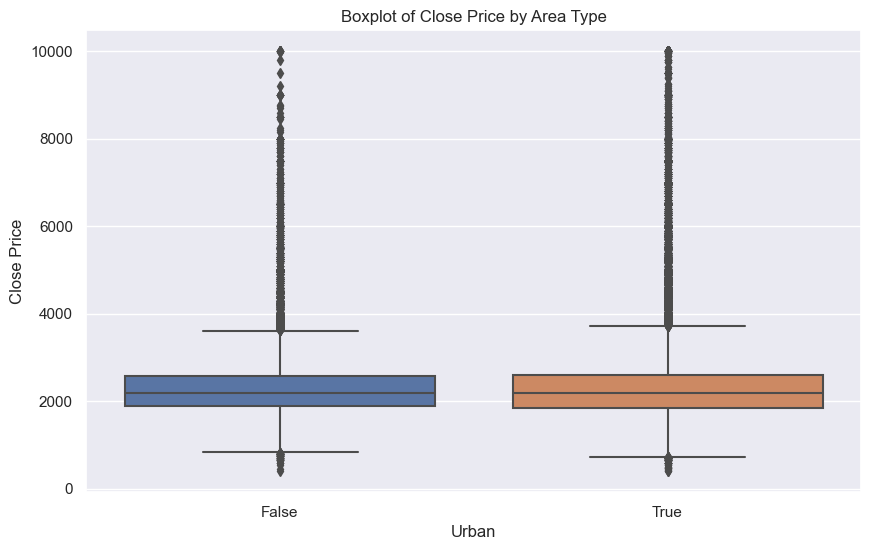

Mean Close Prices:
 Urban
False    2333.547911
True     2350.881854
Name: Close Price, dtype: float64
Median Close Prices:
 Urban
False    2195.0
True     2195.0
Name: Close Price, dtype: float64


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your train DataFrame already includes the 'Area Type' column with 'Rural' or 'Urban' labels
# and the 'Close Price' you want to analyze

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Urban', y='Close Price', data=train)
plt.title('Boxplot of Close Price by Area Type')
plt.xlabel('Urban')
plt.ylabel('Close Price')
plt.show()

mean_prices = train.groupby('Urban')['Close Price'].mean()
median_prices = train.groupby('Urban')['Close Price'].median()
print("Mean Close Prices:\n", mean_prices)
print("Median Close Prices:\n", median_prices)


**Even though I thought this would be a useful analysis, the data shows that there isn't a significant difference between rural and urban homes in the data set. I have chosen to exclude this column from the predictive model for that reason.**

# Market Rent Modeling

I wanted to try two different models to be able to compare and contrast. 
I chose a 

1. Random Forest Model 
2. XGBoost Model [3]

For both I employed an 80/20 training/testing split to ensure that I'm not training on the testing data and keeping data leakage to a minimum. 

For both, I wanted to perform a 10-fold cross validation, given the size of the data set, to normalize some of the RMSE's that we were seeing from each predictive model. [4] 

Finally, I have never used XGBoost in EDA before however I have heard a lot of good things about hyper parameter tuning and things of that nature to enhance predictive power. I looked up the documentation for GridSearch CV [2], which is a parameter optimization function, and implementeed it to improve the XGBoost model. More than anything I thought this was so cool, I had never used either of these libraries before but as you'll see they both turned out quite well. 

# Random Forest Model


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


# Define the features and the target variable
X = train[['Square Feet', 'Bedrooms', 'Bathrooms', 'Year Built', 'Longitude', 'Latitude']]
y = train['Close Price']

X.loc[:, 'Year Built'] = np.log(X['Year Built'])
# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100,  # Number of trees in the forest
                                 random_state=42,   # Seed for reproducibility
                                 max_features='sqrt', # The number of features to consider when looking for the best split
                                 n_jobs=-1)         # Use all processors for training

# Perform 10-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=10, scoring='neg_mean_squared_error')  # Using negative MSE as scoring metric

# Convert the negative MSE scores to positive values
cv_scores = -cv_scores

# Print the mean and standard deviation of the cross-validation scores
print("Mean MSE:", cv_scores.mean())
print("Standard Deviation of MSE:", cv_scores.std())

Mean MSE: 170087.36396358127
Standard Deviation of MSE: 14885.156073920014


# Random Forest with Close Date

# Close Date vs Close Price

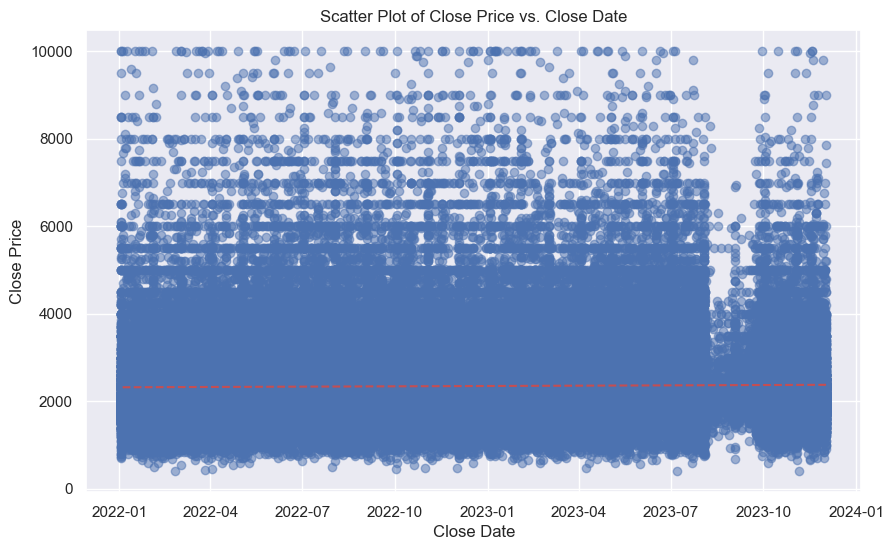

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the train data (ensure the file path is correct)
train = pd.read_csv('TrainingSet.csv')

# Convert 'Close Date' to datetime format
train['Close Date'] = pd.to_datetime(train['Close Date'], format='%m/%d/%Y')

# Filter data if necessary (you can adjust the filter criteria as needed)
# For now, let's not apply any specific filter to 'Close Date' vs 'Close Price'

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(train['Close Date'], train['Close Price'], alpha=0.5)

# Calculate the trend line
# Convert dates to ordinal for trend line calculation
train['Close Date Ordinal'] = train['Close Date'].map(pd.Timestamp.toordinal)
z = np.polyfit(train['Close Date Ordinal'], train['Close Price'], 1)  # Get the coefficients of the line
p = np.poly1d(z)  # Create a polynomial from the coefficients
plt.plot(train['Close Date'], p(train['Close Date Ordinal']), "r--")  # Add the trend line plot

# Set the labels and title
plt.xlabel('Close Date')
plt.ylabel('Close Price')
plt.title('Scatter Plot of Close Price vs. Close Date')

# Show the plot with a grid for better visibility
plt.grid(True)
plt.show()


# Shiller Index vs Close Price 

<Figure size 1200x800 with 0 Axes>

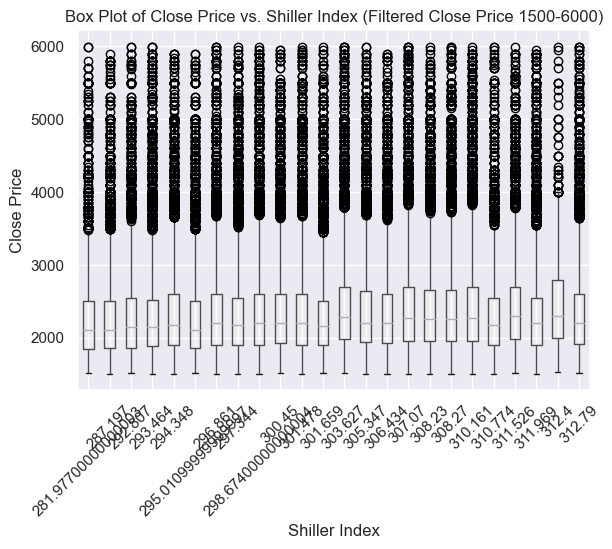

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the train data (ensure the file path is correct)
train = pd.read_csv('TrainingSet.csv')

# Convert 'Close Date' to datetime format using .loc to avoid the warning
train.loc[:, 'Close Date'] = pd.to_datetime(train['Close Date'], format='%m/%d/%Y')

# Load the Shiller Index data with the correct date column name
shiller_data = pd.read_csv('CSUSHPINSA.csv', parse_dates=['DATE'])

# Rename columns for easier access
shiller_data.rename(columns={'DATE': 'Date', 'CSUSHPINSA': 'Shiller Index'}, inplace=True)

# Define a function to categorize dates into the nearest month with Shiller Index available
def get_shiller_index(date, shiller_data):
    date = pd.to_datetime(date)
    # Find the closest Shiller Index date
    closest_date = shiller_data['Date'].iloc[(shiller_data['Date'] - date).abs().argsort()[:1]]
    return shiller_data.loc[shiller_data['Date'] == closest_date.iloc[0], 'Shiller Index'].values[0]

# Apply the function to get the Shiller Index for each 'Close Date'
train['Shiller Index'] = train['Close Date'].apply(get_shiller_index, shiller_data=shiller_data)

# Filter the data for Close Price between 1500 and 6000
filtered_train = train[(train['Close Price'] > 1500) & (train['Close Price'] < 6000)]

# Create a box plot
plt.figure(figsize=(12, 8))
filtered_train.boxplot(column='Close Price', by='Shiller Index', grid=True, rot=45)

# Set the labels and title
plt.xlabel('Shiller Index')
plt.ylabel('Close Price')
plt.title('Box Plot of Close Price vs. Shiller Index (Filtered Close Price 1500-6000)')
plt.suptitle('')  # Suppress the automatic title to avoid duplication

# Show the plot
plt.show()


# RF With Shiller Index

The random forest model ended with an MSE of 170,000. I intuitively thought that latitude and longitude wouldn't have any postive effect on the models predictive accuracy, especially given the large range of coordinates in the training set. However, with the 'Longitude' and 'Latitude' columns excluded the MSE was around 400,000. This was super surprising and also makes me interested in what more detailed and cleaned location data can mean for the accuracy of a future prediction model. 

# XGBoost Model w/ Weighted Moving Average 

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# Assuming 'train' DataFrame is already defined and includes 'Close Date' and 'Close Price' columns

#Compute the weighted moving average of the latest 3 months
def weighted_moving_average(df, window=3):
    weights = np.arange(1, window + 1)
    wm_avg = df['Close Price'].rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return wm_avg

# Adding 'WM_Index' column to the train DataFrame
train['Close Date'] = pd.to_datetime(train['Close Date'])
train = train.sort_values(by='Close Date')
train['WM_Index'] = weighted_moving_average(train)
train['WM_Index'].fillna(train['WM_Index'].mean(), inplace=True)

#Define the features and the target variable
X = train[['Square Feet', 'Bedrooms', 'Bathrooms', 'Year Built', 'Latitude', 'Longitude', 'WM_Index']]
y = train['Close Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create the DMatrix data structure for XGBoost, optimized for performance and efficiency
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5],  # Depth of tree
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'n_estimators': [50, 100, 150],  # Number of boosting rounds
    'subsample': [0.8, 1.0],  # Fraction of samples used in each boosting round
    'colsample_bytree': [0.8, 1.0]  # Fraction of features used in each boosting round
}

# Create the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Extract the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
final_model.fit(X_train, y_train)

# Predicting with the final model
y_pred = final_model.predict(X_test)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(final_model, X, y, cv=10, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive values
cv_scores = -cv_scores

# Print the mean and standard deviation of the cross-validation scores
print("Mean MSE:", cv_scores.mean())
print("Standard Deviation of MSE:", cv_scores.std())


/Users/brianyoung/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
Mean MSE: 95936.97126626286
Standard Deviation of MSE: 5967.181219682431


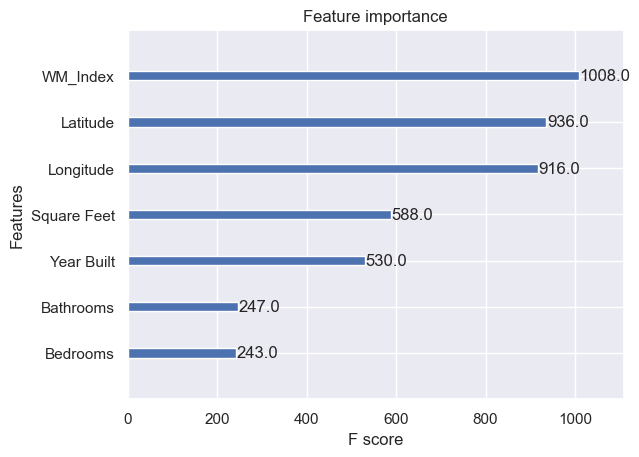

In [20]:
import matplotlib.pyplot as plt 

xgb.plot_importance(final_model)
plt.show()

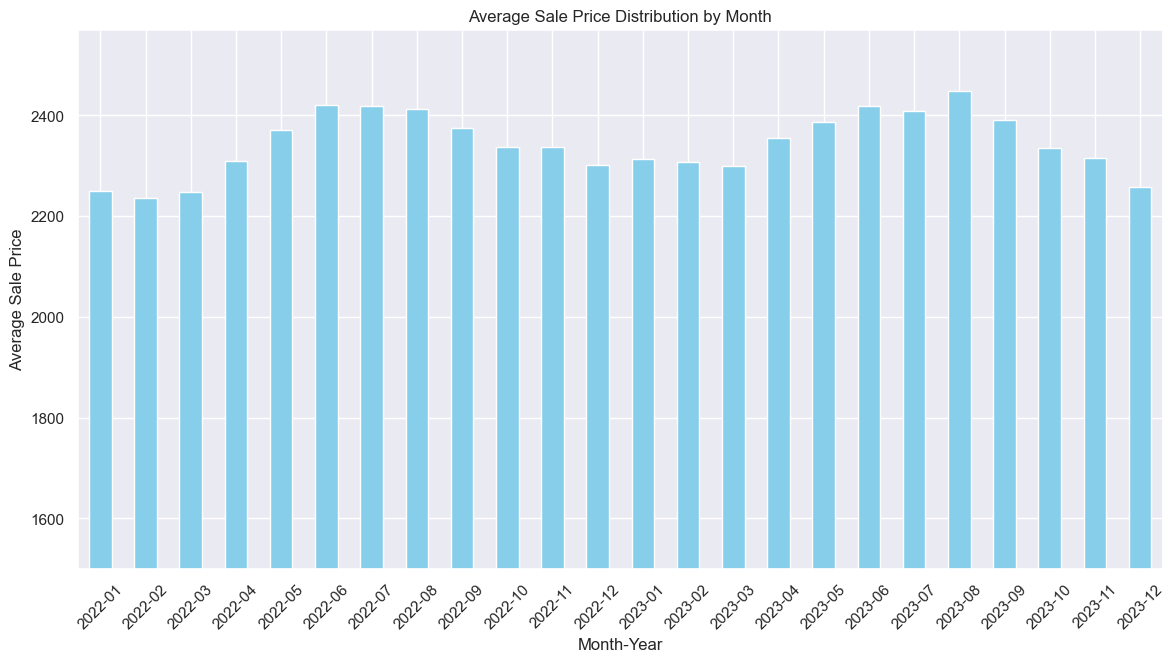

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'train' DataFrame has the 'Close Date' and 'Close Price' and it is already loaded

# Convert 'Close Date' to datetime if not already done
train['Close Date'] = pd.to_datetime(train['Close Date'])

# Extract month and year from 'Close Date'
train['Month-Year'] = train['Close Date'].dt.to_period('M')

# Group by the new 'Month-Year' column and calculate the mean 'Close Price'
monthly_prices = train.groupby('Month-Year')['Close Price'].mean()

# Plotting the distribution
plt.figure(figsize=(14, 7))
monthly_prices.plot(kind='bar', color='skyblue')
plt.title('Average Sale Price Distribution by Month')
plt.xlabel('Month-Year')
plt.ylabel('Average Sale Price')
plt.xticks(rotation=45)
plt.grid(True)

plt.ylim(bottom = 1500)

plt.show()

# XGBoost Shiller Model included 

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Load the train data (ensure the file path is correct)
train = pd.read_csv('TrainingSet.csv')

if train.empty:
    raise ValueError("The 'train' DataFrame is empty. Please check the data source.")

# Load the Shiller Index data with the correct date column name
shiller_data = pd.read_csv('CSUSHPINSA.csv', parse_dates=['DATE'])

# Rename columns for easier access
shiller_data.rename(columns={'DATE': 'Date', 'CSUSHPINSA': 'Shiller Index'}, inplace=True)

# Define a function to categorize dates into the nearest month with Shiller Index available
def get_shiller_index(date, shiller_data):
    date = pd.to_datetime(date)
    # Find the closest Shiller Index date
    closest_date = shiller_data['Date'].iloc[(shiller_data['Date'] - date).abs().argsort()[:1]]
    return shiller_data.loc[shiller_data['Date'] == closest_date.iloc[0], 'Shiller Index'].values[0]

# Define the features and the target variable
X = train[['Square Feet', 'Bedrooms', 'Bathrooms', 'Year Built', 'Longitude', 'Latitude', 'Close Date']]
y = train['Close Price']

# Convert 'Close Date' to datetime format using .loc to avoid the warning
X.loc[:, 'Close Date'] = pd.to_datetime(X['Close Date'], format='%m/%d/%Y')

# Apply the function to get the Shiller Index for each 'Close Date'
X['Shiller Index'] = X['Close Date'].apply(get_shiller_index, shiller_data=shiller_data)

# Check for missing values introduced by get_shiller_index
if X['Shiller Index'].isna().any():
    raise ValueError("Missing values found in 'Shiller Index'. Please check the function get_shiller_index.")

# Drop the 'Close Date' column as it's no longer needed
X = X.drop(columns=['Close Date'])

# Apply logarithmic transformation to 'Year Built'
X['Year Built'] = np.log(X['Year Built'])

# Drop rows with missing values in both X and y
X = X.dropna()
y = y.dropna()

# Check if dropping NaNs caused the dataset to become empty
if X.empty or y.empty:
    raise ValueError("The dataset is empty after dropping missing values. Please check your data.")

# Align the indices of X and y
X = X.loc[y.index]

# Reset index to ensure indices match
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Ensure there are no missing values and the dataset is not empty
if X.empty or y.empty:
    raise ValueError("The dataset is empty after preprocessing. Please check your data.")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the DMatrix data structure for XGBoost, optimized for performance and efficiency
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5],  # Depth of tree
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'n_estimators': [50, 100, 150],  # Number of boosting rounds
    'subsample': [0.8, 1.0],  # Fraction of samples used in each boosting round
    'colsample_bytree': [0.8, 1.0]  # Fraction of features used in each boosting round
}

# Create the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Extract the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the final model with the best parameters
final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
final_model.fit(X_train, y_train)

# Predicting with the final model
y_pred = final_model.predict(X_test)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(final_model, X, y, cv=10, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive values
cv_scores = -cv_scores

# Print the mean and standard deviation of the cross-validation scores
print("Mean MSE:", cv_scores.mean())
print("Standard Deviation of MSE:", cv_scores.std())


This was the XGBoost model using Gridsearch CV to tune some of the hyper parameters for the model. Somehow, it performed worse than the random forest model with a mean MSE of 182,000 which is interesting and is also the reason I am deciding to not move forward with this model for the final prediction. 

# Model Discussion

Overall, both models did a moderately good job at predicting close price in the dataset. I expected the XGBoost model to perform much better however it was ultimately the random forest model that prevailed with a mean MSE of 170102. 

# Future Considerations
**Location data**
Longitude and lattitude data did not make immediate intuitive sense to me. Especially how they were able to improve both predictive models drastically. In future iterations of this model I think being able to understand what exactly about location data is such a good predictor of rent. 

**Evaluating for overfitting** 
my model might overfit due to multi-colinearity of variables. Given more time a more extensive look into the multi-colinearity of the given variables could give insight on overfitting. 


**QAQC Testing**
Performing test to determine if model is overfitting for edge cases/outliers 



# Final Deliverable 

In [ ]:
sns.set_theme()
test = pd.read_csv("TestSet.csv")
print(test.shape)
test.head()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Function to add Market Rent predictions to DataFrame
def add_market_rent(df):
    # Check if the required columns are in the DataFrame
    required_columns = ['Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Square Feet', 'Year Built']
    if not all(column in df.columns for column in required_columns):
        raise ValueError("DataFrame must contain the following columns: " + ", ".join(required_columns))
    
    # Assuming the Random Forest model is already trained and named as 'rf_model'
    rf_model = RandomForestRegressor(n_estimators=100,  # Number of trees in the forest
                                     random_state=42,   # Seed for reproducibility
                                     max_features='sqrt', # The number of features to consider when looking for the best split
                                     n_jobs=-1)         # Use all processors for training
    
    # Training the model here (assuming 'train' is a predefined DataFrame with necessary columns and a 'Close Price' target)
    X_train = train[['Square Feet', 'Bedrooms', 'Bathrooms', 'Year Built', 'Longitude', 'Latitude']]
    y_train = train['Close Price']
    
    X_train.loc[:, 'Year Built'] = np.log(X_train['Year Built'])
    rf_model.fit(X_train, y_train)

    # Organize the features in the input DataFrame to match the model's training features
    X_new = df[['Square Feet', 'Bedrooms', 'Bathrooms', 'Year Built', 'Longitude', 'Latitude']]
    X_new.loc[:, 'Year Built'] = np.log(X_new['Year Built'])
    # Predict using the Random Forest model
    df['Market Rent'] = rf_model.predict(X_new)

    return df

# Example of how to use this function
# Load your data into a DataFrame

input_df = pd.DataFrame(test)

# Add Market Rent predictions
updated_df = add_market_rent(input_df)
updated_df.head()


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# Function to compute the weighted moving average of the latest 3 months
def weighted_moving_average(df, window=3):
    weights = np.arange(1, window + 1)
    wm_avg = df['Close Price'].rolling(window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    return wm_avg

# Function to add Market Rent predictions to DataFrame using XGBoost
def add_market_rent(df):
    required_columns = ['Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Square Feet', 'Year Built']
    if not all(column in df.columns for column in required_columns):
        raise ValueError("DataFrame must contain the following columns: " + ", ".join(required_columns))
    
    # Process 'Year Built' to use in model
    df['Year Built'] = np.log(df['Year Built'])

    # Organize the features in the input DataFrame to match the model's training features
    X_new = df[['Square Feet', 'Bedrooms', 'Bathrooms', 'Year Built', 'Latitude', 'Longitude']]
    if 'WM_Index' not in df.columns:
        raise ValueError("DataFrame must contain the 'WM_Index' column.")

    # Predict using the XGBoost model
    df['Market Rent'] = final_model.predict(X_new)

    return df

# Load and prepare the training data
train['Close Date'] = pd.to_datetime(train['Close Date'])
train = train.sort_values(by='Close Date')
train['WM_Index'] = weighted_moving_average(train)
train['WM_Index'].fillna(train['WM_Index'].mean(), inplace=True)
train['Year Built'] = np.log(train['Year Built'])

# Define the features and the target variable
X = train[['Square Feet', 'Bedrooms', 'Bathrooms', 'Year Built', 'Latitude', 'Longitude', 'WM_Index']]
y = train['Close Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and fit the XGBoost model with GridSearchCV
param_grid = {'max_depth': [3, 4, 5], 'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [50, 100, 150], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract and use the best parameters
best_params = grid_search.best_params_
final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
final_model.fit(X_train, y_train)



# Example usage of the function with an input DataFrame
input_df = pd.DataFrame(test) 
input_df['WM_Index'] = weighted_moving_average(input_df)
input_df['Year Built'] = np.log(input_df['Year Built'])


updated_df = add_market_rent(input_df)
print(updated_df.head())


# Works Cited 

[1] https://stackoverflow.com/questions/48897635/given-a-geographical-coordinate-in-u-s-how-to-find-out-if-it-is-in-urban-or-ru

[2] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[3] https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h-general-parameters

[4] https://machinelearningmastery.com/k-fold-cross-validation/